[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorial_notebooks/8_ml_theory_and_practice_tasks.ipynb) 

# Tutorial 8 - Machine Learning Theory & Practice
In this tutorial, we revisit the ML Theory & Practice session of our BADS lecture, beginning with revisiting the bias-variance trade-off and how the holdout method and cross-validation help us detect overfitting. Afterwards, we look into regularization as a technique to address overfitting and discuss hyperparameter optimization. For these tasks, we use our HMEQ datasets and neural networks as our primary learning algorithm. 

Here is the outline of this tutorial:
1. [Bias, Variance and Overfitting](#bias-variance-and-overfitting)
2. [Regularization](#regularization)
3. [Hyperparameter Optimization](#hyperparameter-optimization)

# Preliminaries



In [1]:
# Imports
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

# Switch off convergence warnings from the NN for cleaner output
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load preprocessed HMEQ data from GitHub
data_url = 'https://raw.githubusercontent.com/Humboldt-WI/bads/master/data/hmeq_prepared.csv'
df = pd.read_csv(data_url)
X = df.copy() # Separate features and target
y = X.pop("BAD")

# Define the initialization value for random numbers (for reproducibility)
seed = 888

# Data partitioning using the holdout method
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Train a simple logistic regression model as benchmark
lr = LogisticRegression(max_iter=100, random_state=seed).fit(X_train, y_train)
yhat = lr.predict_proba(X_test)[:, 1]  # test set predictions
yhat_tr = lr.predict_proba(X_train)[:, 1]  # train set predictions

# Store performance as a nested dictionary
error_lr = {'Train': {'AUC': roc_auc_score(y_train, yhat_tr),
                     'MSE': mean_squared_error(y_train, yhat_tr) },
            'Test': {'AUC': roc_auc_score(y_test, yhat),
                     'MSE': mean_squared_error(y_test, yhat) }}

# Some output
print(f"Data set size (samples x features): {X.shape[0]} x {X.shape[1]}.")
print(f"Logistic Regression train set AUC (MSE): {error_lr['Train']['AUC']:.3f} ({error_lr['Train']['MSE']:.3f})")
print(f"Logistic Regression test  set AUC (MSE): {error_lr['Test']['AUC']:.3f} ({error_lr['Test']['MSE']:.3f})")


Data set size (samples x features): 5960 x 29.
Logistic Regression train set AUC (MSE): 0.907 (0.082)
Logistic Regression test  set AUC (MSE): 0.930 (0.072)


# [Bias, Variance and Overfitting](#bias-variance-and-overfitting)
The *well-known* illustration of the bias-variance trade-off and overfitting is shown below. As discussed, it shows the theoretical development of bias, variance, and various errors. In this part, we strive to reproduce the figure using our HMEQ data and a neural network using the class `MLPClassifier` from  `sklearn.neural_network`.
  
<p align="left">
  <img src="https://raw.githubusercontent.com/Humboldt-WI/demopy/main/overfitting.png" alt="Bias, variance, and overfitting" width="640" />
</p>

Image source: [Geeks for Geeks](https://www.geeksforgeeks.org/machine-learning/ml-bias-variance-trade-off/)


## MLP Classifier
We use the `MLPClassifier` class from the `sklearn.neural_network` module to create and train our neural network, as demononstrated in the [Deep Learning tutorial](https://github.com/Humboldt-WI/bads/blob/master/tutorial_notebooks/7_deep_learning_tasks.ipynb). Below, we reproduce the relevant steps as a starting point for subsequent exercises.

In [2]:
# Train a NN
nn = MLPClassifier(random_state=888, max_iter=100)
nn.fit(X=X_train, y=y_train)
# Compute predictions
yhat_nn = nn.predict_proba(X=X_test)[:, 1]  # get probability of class 1 only
# Compute test set performance in, e.g., AUC
auc_nn = roc_auc_score(y_true=y_test, y_score=yhat_nn)

# Print performance of NN versus logistic regression (-> see preliminaries)
print(f"Test set AUC of the neural network is: {auc_nn:.3f}")
print(f"Test set AUC of logistic regression baseline is: {error_lr['Test']['AUC']:.3f}")


Test set AUC of the neural network is: 0.962
Test set AUC of logistic regression baseline is: 0.930


## Overfitting in neural networks

### The influence of training iterations
In this part, we try to reproduce the above illustration, approximating the complexity of the NN by the **number of training iterations**. To that end, you need to solve the following programming tasks:

#### Exercise 1
- Vary the number of training epochs of the neural network from 50 to 1000 in steps of 50.
- For each configuration, train the model on the training data and evaluate its performance in AUC and MSE on both training and test data.
- Plot the training and test performance against the number of training iterations.
  - Display your results in 1 x 2 grid of two charts:
  - Let the first chart measure model performance by MSE
  - Let the second chart measure model performance by 1-AUC (i.e., to transform AUC as an error measure) 

In [3]:
# Solution to Exercise 1: Varying the number of training iterations

# Candidate settings for the no. of training iterations
iters = np.arange(start=50, stop=1000, step=50)

# Arrays to store performance results
auc_on_ts = []
auc_on_tr = []
mse_on_ts = []
mse_on_tr = []

for i, max_iter in enumerate(iters, start=1):
    # Some printout as the code may take a while to run
    if i % 5 == 0: print(f"Trained {i} out of {len(iters)} networks...")

    # Train a NN
    nn = MLPClassifier(random_state=888, max_iter=max_iter)
    nn.fit(X=X_train, y=y_train)
    
    # Compute predictions for training and test set
    yhat_train = nn.predict_proba(X=X_train)[:, 1]# get probability of class 1 only
    yhat_test = nn.predict_proba(X=X_test)[:, 1]  # get probability of class 1 only

    # Compute and store performance
    auc_on_tr.append(roc_auc_score(     y_true=y_train, y_score=yhat_train))
    mse_on_tr.append(mean_squared_error(y_true=y_train, y_pred= yhat_train))
    
    auc_on_ts.append(roc_auc_score(     y_true=y_test, y_score=yhat_test))
    mse_on_ts.append(mean_squared_error(y_true=y_test, y_pred=yhat_test))


Trained 5 out of 19 networks...
Trained 10 out of 19 networks...
Trained 15 out of 19 networks...


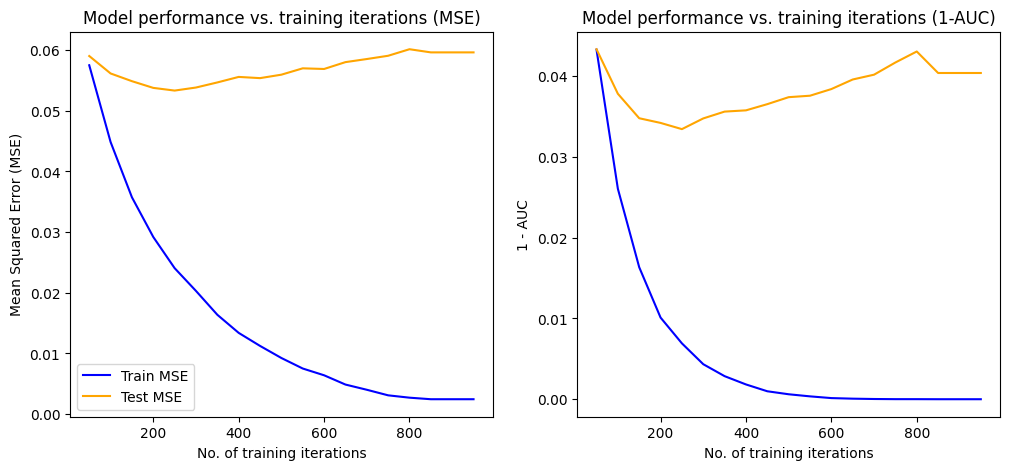

In [4]:
# Plots results
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# MSE plot
ax[0].plot(iters, mse_on_tr, label="Train MSE", color='blue')
ax[0].plot(iters, mse_on_ts, label="Test MSE", color='orange')
ax[0].set_xlabel("No. of training iterations")  
ax[0].set_ylabel("Mean Squared Error (MSE)")
ax[0].set_title("Model performance vs. training iterations (MSE)")
ax[0].legend()  
# 1-AUC plot
ax[1].plot(iters, [1 - auc for auc in auc_on_tr],label="Train 1-AUC", color='blue')        
ax[1].plot(iters, [1 - auc for auc in auc_on_ts],label="Test 1-AUC", color='orange')
ax[1].set_xlabel("No. of training iterations")
ax[1].set_ylabel("1 - AUC")
ax[1].set_title("Model performance vs. training iterations (1-AUC)")
plt.show()

### The influence of model complexity
In this part, we try to reproduce the above illustration, approximating the complexity of the NN by the **number of weights**, which are a function of the number of layers and the size of those layers. So we will have to train multiple NNs with different architecture. Apart from this modification, the steps are similar to the previous task.


#### Exercise 2
- Vary the architecture of the neural network by changing the number of hidden layers and the number of neurons per layer.
  - Recall that `MLPClassifier` expects a *Tuple* as input for the parameter `hidden_layer_sizes`. For example, you can configure a NN with 5 and 3 nodes in the first and second hidden layer, respectively, by setting `hidden_layer_sizes=(5,3)`. 
  - Design the NN in such a way that the total number of nodes increases across the architectures you consider.
- For each NN architecture, train the model on the training data and evaluate its performance in AUC and MSE on both training and test data.
- Collect the results (i.e., MSE and AUC) from each run.
- Plot the training and test performance against the total number of nodes in your NN in 1 x 2 grid of two charts:
  - Let the first chart measure model performance by MSE
  - Let the second chart measure model performance by 1-AUC (i.e., to transform AUC as an error measure) 



In [8]:
# --- Solution to Exercise 2 ---

# 1. Define candidate architectures with increasing total nodes
# We use tuples to define (layer 1, layer 2, ...)
architectures = [
    (2,), (5,), (10,), (25,), (50,),          # Single layer (increasing nodes)
    (50, 25), (50, 50), (100, 50), (100, 100) # Multiple layers
]

# Calculate total number of nodes for the x-axis
total_nodes = [sum(arch) for arch in architectures]

# Arrays to store performance results
auc_tr, auc_ts = [], []
mse_tr, mse_ts = [], []

print("Starting training for different architectures...")

for i, arch in enumerate(architectures):
    # Train the NN with the current architecture
    # max_iter is set higher to ensure convergence for complex models
    nn = MLPClassifier(hidden_layer_sizes=arch, random_state=seed, max_iter=1000)
    nn.fit(X_train, y_train)
    
    # Compute predictions
    yhat_tr = nn.predict_proba(X_train)[:, 1]
    yhat_ts = nn.predict_proba(X_test)[:, 1]
    
    # Store performance metrics
    auc_tr.append(roc_auc_score(y_train, yhat_tr))
    auc_ts.append(roc_auc_score(y_test, yhat_ts))
    mse_tr.append(mean_squared_error(y_train, yhat_tr))
    mse_ts.append(mean_squared_error(y_test, yhat_ts))
    
    print(f"Finished Architecture {i+1}/{len(architectures)}: {arch} (Total nodes: {sum(arch)})")

# 2. Plotting the results in a 1 x 2 grid
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: MSE
ax[0].plot(total_nodes, mse_tr, label="Train MSE", color='blue', marker='o')
ax[0].plot(total_nodes, mse_ts, label="Test MSE", color='orange', marker='o')
ax[0].set_xlabel("Total Number of Nodes")
ax[0].set_ylabel("Mean Squared Error (MSE)")
ax[0].set_title("Model Complexity vs. MSE")
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Chart 2: 1-AUC
ax[1].plot(total_nodes, [1 - a for a in auc_tr], label="Train 1-AUC", color='blue', marker='s')
ax[1].plot(total_nodes, [1 - a for a in auc_ts], label="Test 1-AUC", color='orange', marker='s')
ax[1].set_xlabel("Total Number of Nodes")
ax[1].set_ylabel("1 - AUC")
ax[1].set_title("Model Complexity vs. 1-AUC")
ax[1].legend()
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Trained 5 out of 19 networks...


c:\Users\Fekete Marci\Downloads\Anaconda\envs\bads_env_311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:788: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Trained 10 out of 19 networks...


c:\Users\Fekete Marci\Downloads\Anaconda\envs\bads_env_311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:788: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Trained 15 out of 19 networks...


In [ ]:
# --- Solution to Exercise 2: Plotting Results ---

# 1. Create a figure with two side-by-side subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# --- Plot 1: MSE ---
# Replace 'iters' with 'total_nodes' from your architecture loop
ax[0].plot(total_nodes, mse_on_tr, label="Train MSE", color='blue', marker='o')
ax[0].plot(total_nodes, mse_on_ts, label="Test MSE", color='orange', marker='o')
ax[0].set_xlabel("Total number of nodes (Complexity)") # Updated Label
ax[0].set_ylabel("Mean Squared Error (MSE)")
ax[0].set_title("Model performance vs. Model Complexity (MSE)")
ax[0].legend()  

# --- Plot 2: 1-AUC ---
# Replace 'iters' with 'total_nodes'
ax[1].plot(total_nodes, [1 - auc for auc in auc_on_tr], label="Train 1-AUC", color='blue', marker='s')        
ax[1].plot(total_nodes, [1 - auc for auc in auc_on_ts], label="Test 1-AUC", color='orange', marker='s')
ax[1].set_xlabel("Total number of nodes (Complexity)") # Updated Label
ax[1].set_ylabel("1 - AUC")
ax[1].set_title("Model performance vs. Model Complexity (1-AUC)")
ax[1].legend()

plt.tight_layout()
plt.show()

# Regularization
Regularization is a technique to reduce overfitting by adding a penalty term to the loss function. In the context of the *bias-variance trade-off*, you can think of regularization as a way to introduce bias to reduce variance and ultimately achieve a better balance between the two. 

How to implement this idea? The answer depends on the type of learning algorithm. For regression-type models the answer is: add a complexity penalty to the loss. Large values of the regression coefficients are indicators of complex, unstable models. Possible causes include high dimensionality and multicollinearity. The regularized loss function as the form: 

$$ \min\limits_{\beta} ⁡\mathcal{L} (\beta)+\lambda|(\beta)| $$

This penalty produces sparser models as it forces the coefficients to zero. Furthermore, we also have a new hyperparameter $\lambda$, which governs the strength of regularization. Simply put, $\lambda$ embodies our preference for models that fit the training data more accurately (low $\lambda$) or models that are less complex (high $\lambda$). It is difficult to know suitable settings of $\lambda$ a priori. Thus, we typically tune this *hyperparameter* for each data set. We will get to hyperparamater tuning later in the notebook.

We have discussed common forms of regularization. Let's revisit those in more detail.

## Lasso or L1 Regularization
The Least Absolute Shrinkage and Selection Operator or LASSO set the penalty to equal to the sum of the absolute coefficients multiplied by some *shrinkage* value, denoted by $\lambda$. The LASSO optimization problem can be written as:

$$ \arg\min_{\beta_j} \sum_{i=1}^{n}(y_i - \sum_{j}x_{ij} \beta_j)^2 + \lambda \sum_{j=1}^{p} |\beta_j | $$

Note that it is **crucial to standardize numerical features when using Lasso**. Standardization is crucial to ensure that every feature, independent of the magnitude of common feature values (e.g., several thousands for a feature *salary* as opposed to small int value for a feature *years of education*) has the same chances of *surviving* lasso regularization. Here, survive means receiving a non-zero coefficient. Intuitively, shrinking the coefficient of a feature with large values (e.g., salary) will reduce the penalty more than shrinking the coefficient of a feature with smaller feature values (e.g., years of education). Lasso performs **embedded feature selection** meaning that it is likely to set some coefficients to zero, which is equivalent to discarding the feature. If two or more variables are highly correlated, lasso will arbitrarily select one of them and assign a non-zero coefficient, while the other correlated features are likely to receive a coefficient value of zero. This behavior is sometimes desirable, for example to remove *redundant features* but also cause problems, for example if the features are dummy codes originating from the same categorical variable.

## Ridge or L2 Regularization
Ridge regression is similar to lasso regression with the difference of the penalty being equal to the sum of the **square of the coefficients** multipled by some shrinkage value. Here is the objective function for L2 regularization:

$$ \arg\min_{\beta_j} \sum_{i=1}^{n}(y_i - \sum_{j}x_{ij} \beta_j)^2 + \lambda \sum_{j=1}^{p} |\beta_j^2 | $$

Again, it is crucial to **standardize all continuous variables** before performing ridge regression. The reason is the same as for Lasso. Ridge regression never really sets coefficient values to zero due to the square. So, if all parameters are believed to hold some importance, it may be better to use this method of regularization. Note that ridge regression only works if the number of coefficients is less than the number of observations.

## Elastic Net
Elastic Net (enet) is a combination of L1 and L2 regularization. It is best used when an analyst is unsure whether ridge or lasso is more suitable for a given data set. The enet penalty specifies two separate shrinkage values. 

$$ \arg\min_{\beta_j} \sum_{i=1}^{n}(y_i - \sum_{j}x_{ij} \beta_j)^2 + \lambda_1 \sum_{j=1}^{p} |\beta_j | + \lambda_2 \sum_{j=1}^{p} |\beta_j^2 | $$

One of the bigger disadvantages of enet is the computational cost required to find the best combination of the two shrinkage values. It is also important to check if lasso alone might have done a better job at preventing overfitting.

## Working examples of regularized logistic regression
The *sklearn* implementation of logistic regression supports L1, L2, and elastic net regularization. The relevant class is `LogisticRegression` from the module `sklearn.linear_model`. The type of regularization is specified via the parameter `penalty`, which can take the values `'l1'`, `'l2'`, and `'elasticnet'`. The strength of regularization is controlled by the parameter `C`, which is the inverse of the shrinkage value $\lambda$. Thus, smaller values of `C` imply stronger regularization. When using elastic net regularization, you also need to specify the parameter `l1_ratio`, which controls the relative weight of L1 and L2 regularization. A value of `l1_ratio=0` implies pure L2 regularization, while a value of `l1_ratio=1` implies pure L1 regularization.

Below, we train and evaluate a logistic regression model with L2 regularization on our HMEQ data, and compare the result to the baseline model, our logistic regression model `lr`, which was trained without was adding a regularization penalty to the loss function (see, [Preliminaries](#Preliminaries)). Note that not all solvers that *sklearn* offers for logistic regression support all types of regularization. For L1 regularization, we use the solver `'saga'`, which supports both L1 and elastic net regularization.

In [9]:
# Logistic regression with L1 penalty
lr_l1 = LogisticRegression(penalty='l1', solver='saga', C=.25, random_state=888) 
lr_l1.fit(X_train, y_train)

,penalty,'l1'
,dual,False
,tol,0.0001
,C,0.25
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,888
,solver,'saga'
,max_iter,100
,multi_class,'deprecated'


In [16]:
l1_penalty = np.sum(np.abs(lr_l1.coef_))
print(f"L1 penalty (sum of absolute coefficients) is: {l1_penalty:.3}")

L1 penalty (sum of absolute coefficients) is: 16.4


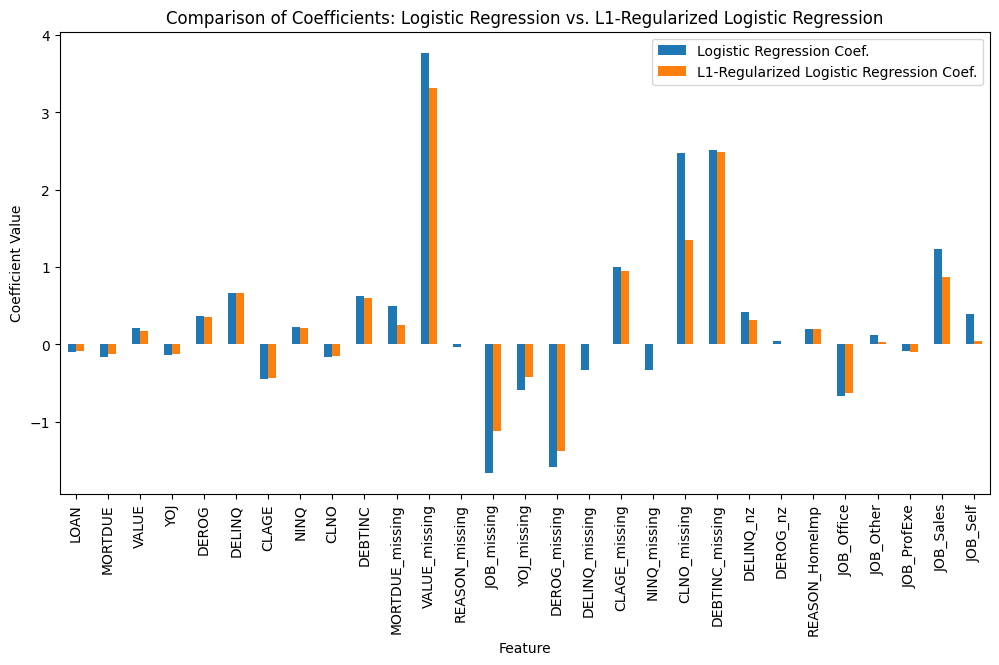

In [10]:
# Compare the estimated coefficients using a bar plot
coef_df = pd.DataFrame({'Feature': X.columns,
                        'Logistic Regression Coef.': lr.coef_.flatten(),
                        'L1-Regularized Logistic Regression Coef.': lr_l1.coef_.flatten()})

coef_df.set_index('Feature').plot(kind='bar', figsize=(12, 6))
plt.title("Comparison of Coefficients: Logistic Regression vs. L1-Regularized Logistic Regression")
plt.ylabel("Coefficient Value") 
plt.show()

We clearly see how the average magnitude of the coefficients is reduced when using L1 regularization. Furthermore, some coefficients are set to zero, indicating that those features were discarded by the regularization process. To get a better feeling for the effect of the hyperparameter `C`, it is useful to rerun the previous code multiple times with different settings of `C`. Recall that smaller values imply stronger regularization. 

### Exercise 3 Benchmarking regularized vs. non-regularized logistic regression
This exercises involves systematically benchmarking different regression models to each other. Although the notebook already trained some models, it is best to start from scratch to have a self-contained exercise solution in the end. To achieve this: 
- Train four logistic regression models:
  - A baseline model without regularization
  - A model with L1 regularization  
  - A model with L2 regularization
  - A model with elastic net regularization
  - Set relevant hyperparameters to reasonable values. You may want to experiment with different settings of `C` and `l1_ratio` (for elastic net).
- Evaluate all four models on the test data using AUC and MSE as performance measures.
- Create a ROC chart showing all four models to facilitate a comparision. We suggest you use the class `RocCurveDisplay` from the module `sklearn.metrics` for this purpose.

In [ ]:
# Solution to Exercise 3: Benchmarking regularized vs. non-regularized logistic regression


# Hyperparameter Optimization
A limitation of the benchmarking exercise above is that we had to set hyperparameters manually. In practice, it is often unclear which hyperparameter settings are best for a given data set. Thus, we need systematic ways to find good hyperparameter configurations. Hyperparameter optimization (HPO) is the process of finding the best hyperparameter configuration for a given learning algorithm and data set. Hyperparameters are parameters that are not learned from the data but are set before training. Examples include the learning rate, the number of hidden layers in a neural network, or the regularization strength in regression models. The goal of HPO is to find the hyperparameter values that lead to the best model performance on unseen data.

## Grid search
The lecture introduced grid search as a simple yet effective method for hyperparameter optimization. The idea is to define a grid of possible hyperparameter values and evaluate the model's performance for each combination of these values. The combination that yields the best performance on a validation set is selected as the optimal hyperparameter configuration.

<p align="left">
  <img src="https://raw.githubusercontent.com/Humboldt-WI/demopy/main/gridsearch.png" alt="Grid search" width="640" />
</p>

The key class in *sklearn* for hyperparameter optimization using grid search is `GridSearchCV` from the module `sklearn.model_selection`. This class implements grid search with cross-validation to systematically explore a predefined set of hyperparameter values. Below, we demonstrate how to use `GridSearchCV` to optimize the hyperparameter `C` and the type of penalty for a regularized logistic regression model. Given that HPO is about finding a *best* model, we need to select a performance metric to optimize. Here, we use AUC as our performance metric.



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import RocCurveDisplay

# grid of hyperparameter values for tuning
C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10]
penalties = ['l1', 'l2']

gcv = GridSearchCV(
    estimator=LogisticRegression(solver='saga', random_state=888),
    param_grid={'C': C_values, 'penalty': penalties},  # the grid of hyperparameters to search
    scoring='roc_auc',  # metric to optimize
    cv=5,  # number of cross-validation folds
    n_jobs=-1  # use all available CPU cores

)
# Start optimization
gcv.fit(X_train, y_train)

# Best hyperparameter setting
best_params = gcv.best_params_
print(f"Best hyperparameters found: {best_params}")
# Evaluate the best model on the test set
best_model = gcv.best_estimator_

RocCurveDisplay.from_estimator(best_model, X_test, y_test, name="Best Model")
plt.show()



### Exercise 4 NN hyperparameter optimization
Considering all previous results, the performance of the logistic regression models did not vary much. Your last exercise is to extend the hyperparameter optimization example above to include neural networks. More specifically, perform grid-search to identify a high-performing NN architecture by searching over the following hyperparameters: 
- Number of hidden layers: consider architectures with 1, 2, and 3 hidden layers.
- Number of neurons per hidden layer: consider 5, 20, and 50 neurons per hidden layer.
- Degree of L2 regularization: 
  - Note that MLPClassifier supports only L2 regularization via the argument `alpha` of `MLPClassifier`
  - consider values of 0.001, 0.01, and 0.1.
- Learning rate: consider learning rates of 0.001, 0.01, and 0.1.   
- Use AUC as the performance metric to optimize.
- PLot the ROC curve of the best model and that of a NN with default hyperparameters using `ROCurveDisplay`.

Note that the search over this comprehensive hyperparameter space may take a while. Set the argument `verbose` of `GridSearchCV` to obtain some status updates while the search is running.

And don't be too disappointed when the performance gain over the default model is less than expected ;)

In [ ]:
# Solution to exercise 4: NN hyperparameter optimization
